In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer,PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Dense, Dropout,GlobalAveragePooling1D

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   clean_text  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


# Feature Engineering

### Text

In [ ]:
lemma = nltk.wordnet.WordNetLemmatizer()
def clean_text(text):
    # Delete URL
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Delete Hashtag and etc
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r"'s\b", " is", text)
    text = re.sub(r"'m\b", " am", text)
    text = re.sub(r"'re\b", " are", text)
    text = re.sub(r'[^A-Za-z\s]', '', text)

    text = text.lower()
    text = text.strip()

    text = ' '.join([lemma.lemmatize(word) for word in text.split()])

    return text

In [ ]:
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [ ]:
train_df[['text','clean_text']].head(10)

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deed are the reason of this earthquake may...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all resident asked to shelter in place are bei...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order in ca...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska a sm...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy closed in both...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain cause flash flooding...
7,I'm on top of the hill and I can see a fire in...,i am on top of the hill and i can see a fire i...
8,There's an emergency evacuation happening now ...,there is an emergency evacuation happening now...
9,I'm afraid that the tornado is coming to our a...,i am afraid that the tornado is coming to our ...


# Training

In [ ]:
vocab_size = 10000
embedding_dim = 32
max_length = 50

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

X_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
X = pad_sequences(X_sequences, padding='post', maxlen=max_length)

# Target feature
y = train_df['target']
y = np.array(y)

In [ ]:
# Split dataset as train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create Model

In [ ]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

### Training

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-6,restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test),callbacks=[lr_scheduler], verbose=2)

Epoch 1/30
191/191 - 3s - 13ms/step - accuracy: 0.5696 - loss: 0.6810 - val_accuracy: 0.5739 - val_loss: 0.6723 - learning_rate: 5.0000e-04
Epoch 2/30
191/191 - 1s - 6ms/step - accuracy: 0.6036 - loss: 0.6515 - val_accuracy: 0.7807 - val_loss: 0.6214 - learning_rate: 5.0000e-04
Epoch 3/30
191/191 - 1s - 7ms/step - accuracy: 0.7631 - loss: 0.5554 - val_accuracy: 0.7971 - val_loss: 0.5252 - learning_rate: 5.0000e-04
Epoch 4/30
191/191 - 1s - 5ms/step - accuracy: 0.8108 - loss: 0.4637 - val_accuracy: 0.7971 - val_loss: 0.4791 - learning_rate: 5.0000e-04
Epoch 5/30
191/191 - 1s - 5ms/step - accuracy: 0.8368 - loss: 0.4023 - val_accuracy: 0.7820 - val_loss: 0.4762 - learning_rate: 5.0000e-04
Epoch 6/30
191/191 - 1s - 7ms/step - accuracy: 0.8475 - loss: 0.3690 - val_accuracy: 0.7965 - val_loss: 0.4631 - learning_rate: 5.0000e-04
Epoch 7/30
191/191 - 2s - 9ms/step - accuracy: 0.8677 - loss: 0.3257 - val_accuracy: 0.7978 - val_loss: 0.4624 - learning_rate: 2.5000e-04
Epoch 8/30
191/191 - 2s - 

### Test

In [ ]:
y_pred_test = model.predict(X_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy: 0.8095863427445831
F1 Score: 0.7672552166934189


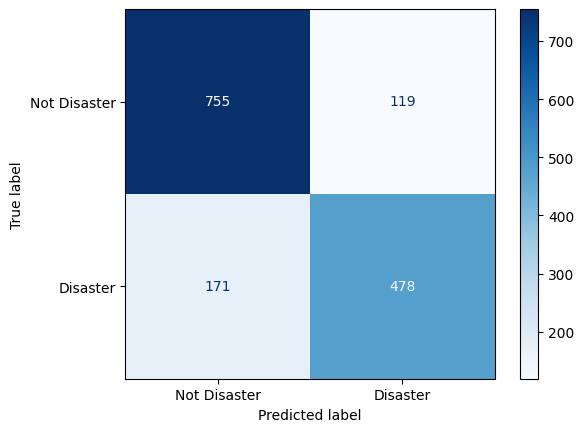

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        np.where(y_pred_test[:,0]>0.5,1,0),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

tn, fp, fn, tp = confusion_matrix(y_test, np.where(y_pred_test[:,0]>0.5,1,0)).ravel()
f1_score = tp / (tp+((fn+fp)/2))
print(f"Accuracy: {accuracy_score(y_test, np.where(y_pred_test[:,0]>0.5,1,0))}")
print(f"F1 Score: {f1_score}")

# Submission

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
X_sequences_sub = tokenizer.texts_to_sequences(test_df['clean_text'])
X_sub = pad_sequences(X_sequences_sub, padding='post', maxlen=max_length)

In [ ]:
y_pred=model.predict(X_sub)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
sample_submission["target"] = np.where(y_pred[:,0]>0.5,1,0)

In [ ]:
sample_submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.378793
std,3146.427221,0.485161
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [ ]:
sample_submission.to_csv("final_submission.csv", index=False)